# Winter Predictor Based on ERA-int

[List of Variables](#varlist)

[Database Exploration](#db)

In [3]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid
import pymongo
from pprint import pprint
from datetime import datetime, timedelta, date

In [5]:
# Open any era_int file
nc_file = '/home/dmasson/data/era-interim/era-int_multivarm1_1979-01-01_to_2017-08-31.nc'
fh = Dataset(nc_file, mode='r')

## List of Variables <a id='varlist'></a>

In [12]:
print(fh.variables)

OrderedDict([('longitude', <class 'netCDF4._netCDF4.Variable'>
float32 longitude(longitude)
    units: degrees_east
    long_name: longitude
unlimited dimensions: 
current shape = (480,)
filling off
), ('latitude', <class 'netCDF4._netCDF4.Variable'>
float32 latitude(latitude)
    units: degrees_north
    long_name: latitude
unlimited dimensions: 
current shape = (241,)
filling off
), ('time', <class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    units: hours since 1900-01-01 00:00:0.0
    long_name: time
    calendar: gregorian
unlimited dimensions: time
current shape = (464,)
filling off
), ('ci', <class 'netCDF4._netCDF4.Variable'>
int16 ci(time, latitude, longitude)
    scale_factor: 1.52594875864e-05
    add_offset: 0.499992370256
    _FillValue: -32767
    missing_value: -32767
    units: (0 - 1)
    long_name: Sea-ice cover
unlimited dimensions: time
current shape = (464, 241, 480)
filling off
), ('sst', <class 'netCDF4._netCDF4.Variable'>
int16 sst(time, latitude, longitude)

In [13]:
lons = fh.variables['longitude'][:]
lats = fh.variables['latitude'][:]
t2m = fh.variables['t2m'][:]
fh.close()

In [14]:
# Shift the grid so lons go from -180 to 180 instead of 0 to 360.
t2m_shift, lons_shift = shiftgrid(
    lon0=180., datain=t2m, lonsin=lons, start=False)

lon, lat = np.meshgrid(lons_shift, lats)
this_field = t2m_shift[11, :, :]

In [16]:
t2m_shift.shape


(464, 241, 480)

Get parameters for the stereographic projection

In [17]:
m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90,\
            llcrnrlon=0, urcrnrlon=360, resolution='c', lon_0=0)

In [18]:
lon, lat = np.meshgrid(lons, lats)
xi, yi = m(lon, lat)

In [19]:
yi

array([[ 90.  ,  90.  ,  90.  , ...,  90.  ,  90.  ,  90.  ],
       [ 89.25,  89.25,  89.25, ...,  89.25,  89.25,  89.25],
       [ 88.5 ,  88.5 ,  88.5 , ...,  88.5 ,  88.5 ,  88.5 ],
       ..., 
       [-88.5 , -88.5 , -88.5 , ..., -88.5 , -88.5 , -88.5 ],
       [-89.25, -89.25, -89.25, ..., -89.25, -89.25, -89.25],
       [-90.  , -90.  , -90.  , ..., -90.  , -90.  , -90.  ]], dtype=float32)

Plot Data

/home/dmasson/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3342: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/dmasson/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3381: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


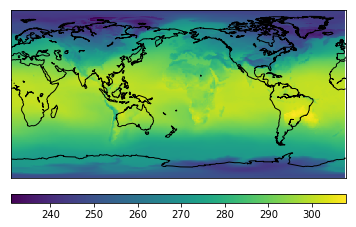

In [20]:
cs = m.pcolor(xi, yi, np.squeeze(this_field))
m.drawcoastlines()
cbar = m.colorbar(cs, location='bottom', pad="10%", cmap=plt.cm.RdBu_r)
plt.show()

In [21]:
# Shift the grid so lons go from -180 to 180 instead of 0 to 360.
data_cyclic, lons_cyclic = addcyclic(np.squeeze(this_field), lons)
data_cyclic, lons_cyclic = shiftgrid(180., data_cyclic, lons_cyclic, start=False)

In [22]:
m2 = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90,llcrnrlon=-180, urcrnrlon=180, resolution='c', lon_0=0)
m2.drawcoastlines()
lon, lat = np.meshgrid(lons_cyclic, lats)
xi2, yi2 = m2(lon, lat)


/home/dmasson/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3342: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/dmasson/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3381: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


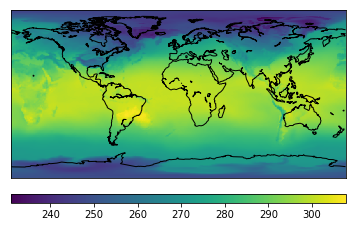

In [23]:
cs2 = m2.pcolor(xi2, yi2, np.squeeze(data_cyclic))
cbar = m2.colorbar(cs2, location='bottom', pad="10%")
plt.show()

## Database exploration <a id='db'></a>

In [4]:
mongo_host_local = 'mongodb://localhost:27017/'
mg = pymongo.MongoClient(mongo_host_local)

In [5]:
pprint(mg.database_names())

['ECMWF', 'local']


In [6]:
db = mg.ECMWF
db.collection_names()

['ERAINT_grid', 'ERAINT_monthly', 'system.indexes']

In [7]:
con = db.ERAINT_grid
fo = con.find_one()

In [9]:
pprint(fo)

{'_id': ObjectId('5a088e938cb6b80d9b4c7f93'),
 'id_grid': 1,
 'loc': {'coordinates': [-180.0, 90.0], 'type': 'Point'}}


In [10]:
con.count()

115680

In [11]:
#con.drop()

In [11]:
ind = con.index_information()
pprint(ind)

{'_id_': {'key': [('_id', 1)], 'ns': 'ECMWF.ERAINT_grid', 'v': 1},
 'loc_2dsphere_id_grid_1': {'2dsphereIndexVersion': 2,
                            'key': [('loc', '2dsphere'), ('id_grid', 1)],
                            'ns': 'ECMWF.ERAINT_grid',
                            'v': 1}}


In [12]:
con_data = db.ERAINT_monthly
fo = con_data.find_one()
pprint(fo)

{'_id': ObjectId('5a089e0f8cb6b81914062592'),
 'al': 0.07,
 'ci': 1.0,
 'd2m': 235.27,
 'date': datetime.datetime(1979, 2, 1, 0, 0),
 'hcc': 0.2,
 'id_grid': 1,
 'istl1': 238.26,
 'lcc': 0.58,
 'mcc': 0.26,
 'msl': 101948.67,
 'si10': 6.1,
 'skt': 238.46,
 'sp': 101948.57,
 'sst': 271.46,
 'stl1': 238.47,
 't2m': 238.56,
 'u10': 1.18,
 'v10': -0.01,
 'year': 1979}


In [ ]:
this_day = datetime(1995,1 ,1)
for doc in con_data.find({'date': this_day}).limit(2):
    pprint(doc)

In [27]:
# Drop the daily data collection 
#con_data.drop()

In [33]:
fo = con_data.find_one()
pprint(fo)

{'_id': ObjectId('5a089e0f8cb6b81914062592'),
 'al': 0.07,
 'ci': 1.0,
 'd2m': 235.27,
 'date': datetime.datetime(1979, 2, 1, 0, 0),
 'hcc': 0.2,
 'id_grid': 1,
 'istl1': 238.26,
 'lcc': 0.58,
 'mcc': 0.26,
 'msl': 101948.67,
 'si10': 6.1,
 'skt': 238.46,
 'sp': 101948.57,
 'sst': 271.46,
 'stl1': 238.47,
 't2m': 238.56,
 'u10': 1.18,
 'v10': -0.01,
 'year': 1979}


In [39]:
# How many documents are in the daily data collection
con_data.count()

53675520

In [34]:
alldays = con_data.distinct(key='date')
alldays

[datetime.datetime(1979, 2, 1, 0, 0),
 datetime.datetime(1979, 1, 1, 0, 0),
 datetime.datetime(1979, 3, 1, 0, 0),
 datetime.datetime(1979, 4, 1, 0, 0),
 datetime.datetime(1979, 5, 1, 0, 0),
 datetime.datetime(1979, 6, 1, 0, 0),
 datetime.datetime(1979, 7, 1, 0, 0),
 datetime.datetime(1979, 8, 1, 0, 0),
 datetime.datetime(1979, 9, 1, 0, 0),
 datetime.datetime(1979, 10, 1, 0, 0),
 datetime.datetime(1979, 11, 1, 0, 0),
 datetime.datetime(1979, 12, 1, 0, 0),
 datetime.datetime(1980, 1, 1, 0, 0),
 datetime.datetime(1980, 2, 1, 0, 0),
 datetime.datetime(1980, 3, 1, 0, 0),
 datetime.datetime(1980, 4, 1, 0, 0),
 datetime.datetime(1980, 5, 1, 0, 0),
 datetime.datetime(1980, 6, 1, 0, 0)]

In [40]:
con_data.index_information()

{'_id_': {'key': [('_id', 1)], 'ns': 'ECMWF.ERAINT_monthly', 'v': 1}}

# Explore precip data

In [ ]:
# Open any era_int file
from netCDF4 import Dataset, netcdftime, num2date, date2num, date2index
import pandas as pd
nc_file = '/mnt/GIS1/era-interim/era-int_multivar_1980-01-01_to_1984-12-31.nc'
fh = Dataset(nc_file, mode='r')
lons = fh.variables['longitude'][:]
lats = fh.variables['latitude'][:]
nctime = fh.variables['time'][:]
t_unit = fh.variables['time'].units
time = num2date(nctime, units=t_unit)
# Create a data frame
df = pd.DataFrame({'time': time})
df = df.assign(date=df.time.dt.date)

# Do some aggregation
gdf = pd.DataFrame(df.groupby('date').size().rename('ndoc')).reset_index()
df2 = pd.merge(left=df, right=gdf, on="date")
df3 = df2.query('ndoc == 2')
days = df3.date.drop_duplicates()

In [ ]:
 # Choose one arbitrary day
this_day = days.iloc[2]   
print this_day
# Extract the data for this day out of the nc file
times = df3[df3.date == this_day].time
ind = date2index(dates=times.tolist(), nctime=fh.variables['time'])
t2m = fh.variables['t2m'][ind]
tp = fh.variables['tp'][ind]
# Do the aggregation over the two 12-hours fields
# The aggregation depends on the variable, more details under:
# https://software.ecmwf.int/wiki/pages/viewpage.action?pageId=56658233
t2m_daily = t2m.mean(axis=0) - 273.15  # conversion to Celsius
tp_daily = (tp.sum(axis=0) * 1000)  # conversion to mm/day

In [ ]:
# Shift the grid so lons go from -180 to 180 instead of 0 to 360.
tp_daily_cycl, lons_cyclic = addcyclic(np.squeeze(tp_daily), lons)
tp_daily_cycl, lons_cyclic = shiftgrid(180., tp_daily_cycl, lons_cyclic, start=False)
lon, lat = np.meshgrid(lons_cyclic, lats)

In [ ]:
tp_daily_cycl.shape

In [ ]:
m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90,llcrnrlon=-180, urcrnrlon=180, resolution='c', lon_0=0)
m.drawcoastlines()
lon, lat = np.meshgrid(lons_cyclic, lats)
xi, yi = m(lon, lat)
cs = m.pcolor(xi, yi, np.squeeze(tp_daily_cycl), vmin=0, vmax=20)
cbar = m.colorbar(cs, location='bottom', pad="10%")
plt.show()